# Rat cortex Marques - file c1

author: steeve.laquitaine@epfl.ch

**Summary**:
- download from firefox (Safari needs update) from https://drive.google.com/drive/folders/13GCOuWN4QMW6vQmlNIolUrxPy-4Wv1BC, unzip then copy to path `/nfs4/bbp.epfl.ch/user/laquitai/` available on cluster
- probe channel coordinates - id mapping: https://github.com/kampff-lab/sc.io/blob/master/Paired%20Recordings/Preprint%20Code/npx_map.csv
- data description: https://docs.google.com/spreadsheets/d/1GIYORXVy8ZsVxagq0870aIOwm6Oi-5Hl/edit#gid=702947554
- 4-column geometry
- contact ids have 0 at the bottom (probe depth between 2500 and 3800) moving up to 383 (L1)
- not all sites are in cortex: the deeper sites (starting from 0) are in subcortical areas (depth between 2500 and 3800)
- cortical thickness: 1,800 to 2,500 μm
- according to the authors: 700 - 1600 um from pial surface (i.e., location of top recording sites 380,382,381, 383) are in Layer 5 (where they patch-clamped most cells)
- available raw data has only undergone offset subtraction
- in paper, traces underwent high-pass filtering at 200 Hz and common-average referencing

### Data description

In [9]:
import os
import spikeinterface as si
import spikeinterface.extractors as se
from matplotlib import pyplot as plt
from probeinterface.plotting import plot_probe
import numpy as np 
from probeinterface import (
    generate_multi_columns_probe
    )
import MEAutility as MEA

SAMPFREQ = 30000
data_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/raw/vivo_rat_cortex_marques/c1/c1_npx_raw-001.bin"

- open sourced raw data has only undergone offset subtraction


In [4]:
# load recording
Recording = si.read_binary(data_path, sampling_frequency=30000, num_chan=384, dtype='int16')

In [10]:
print(Recording.get_total_duration()) # 4.5 min
print(Recording.get_sampling_frequency())
print(Recording.is_filtered())

270.01123333333334
30000
False


### Wire probe

In [98]:
def wire_probe(Recording):

    # reconstruct probe
    n_contacts = 384
    N_CONTACT_PER_COL = 96
    N_COLS = 4

    # get Neuropixels-384 as a model to replicate
    mea_ProbeNeuropix384_2D = MEA.return_mea("Neuropixels-384")
    mea_ProbeNeuropix384_2D_params = MEA.return_mea_info("Neuropixels-384")

    # set pitches (y:1 is not intuitive but see [1])
    Y_PITCH = (mea_ProbeNeuropix384_2D_params["pitch"][0],)  # inter-columns
    X_PITCH = (mea_ProbeNeuropix384_2D_params["pitch"][1],)  # inter-row
    STAGGER = mea_ProbeNeuropix384_2D_params["stagger"]

    # create 2D ProbeInterface probe object
    probe = generate_multi_columns_probe(
        num_columns=N_COLS,
        num_contact_per_column=N_CONTACT_PER_COL,
        xpitch=X_PITCH,
        ypitch=Y_PITCH,
        y_shift_per_column=[0, STAGGER, 0, STAGGER],
        contact_shapes=mea_ProbeNeuropix384_2D_params["shape"],
        contact_shape_params={"width": mea_ProbeNeuropix384_2D_params["size"]},
    )

    # make 3D
    probe = probe.to_3d(axes="yz")

    # set the contact ids and channel ids to start from 0
    # create Marques site - mapping
    contact_ids = np.vstack([np.arange(0,384,4),
    np.arange(2,384,4),
    np.arange(1,384,4),
    np.arange(3,384,4)]).reshape(1,384).squeeze()

    probe.set_contact_ids(contact_ids)
    probe.set_device_channel_indices(contact_ids)
    return Recording.set_probe(probe)

Recording = wire_probe(Recording)

In [99]:
# check probe
try:
    probe = Recording.get_probe()
    print("A probe is attached.")
except:
    print("No probe was found.")

A probe is attached.


In [100]:
probe.contact_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124', '125', '126', '127',
       '128', '129', '130', '131', '132', '133', '134', '135', '136',
       '137', '138', '139', '140', '141', '142', '143', '144

### Plot site mapping

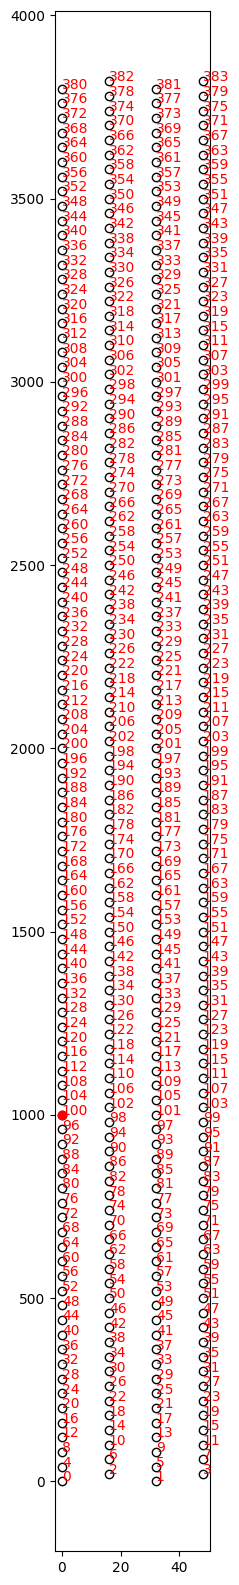

In [101]:
# plot
contact_coord = probe.contact_positions
contact_ids = probe.contact_ids

# plot file contact with ids 
fig, ax = plt.subplots(1,1, figsize=(2,20))
ax.plot(contact_coord[:,1], contact_coord[:,2], "o", markerfacecolor="w", color="k");
for ix in range(len(contact_ids)):
    if ix % 1 == 0:
        ax.text(
            contact_coord[ix, 1],
            contact_coord[ix, 2],
            "%s" % (str(contact_ids[ix])),
            size=10,
            zorder=100,
            color="r",
        )
plt.plot(contact_coord[100, 1], contact_coord[100, 2],"ro");

/tmp/ipykernel_121297/3598172735.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(1,1, figsize=(15,1))


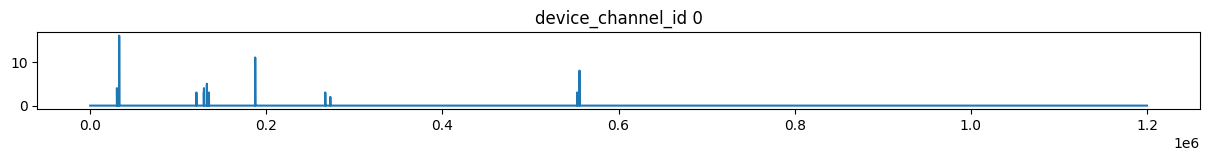

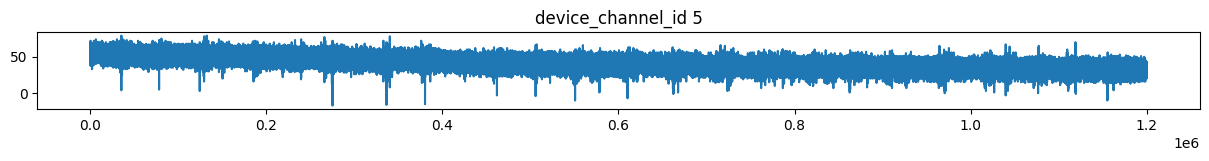

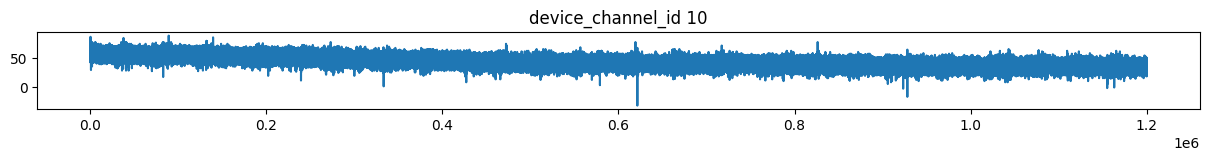

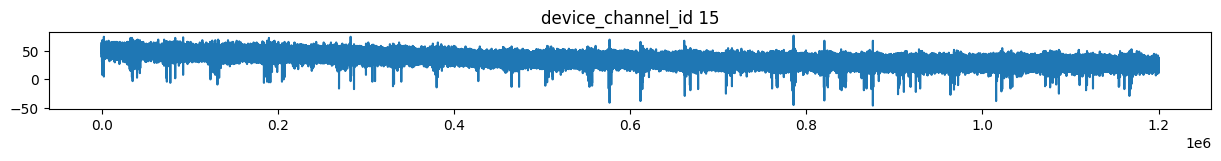

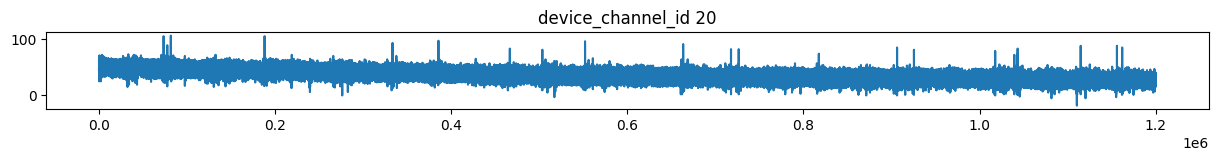

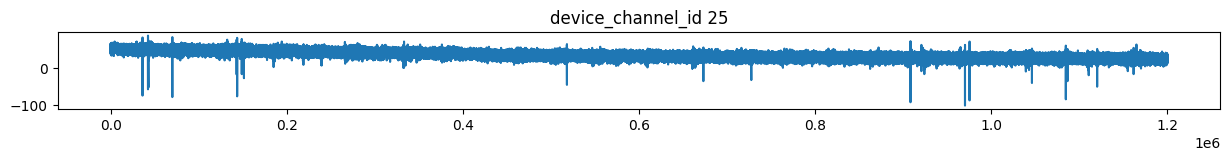

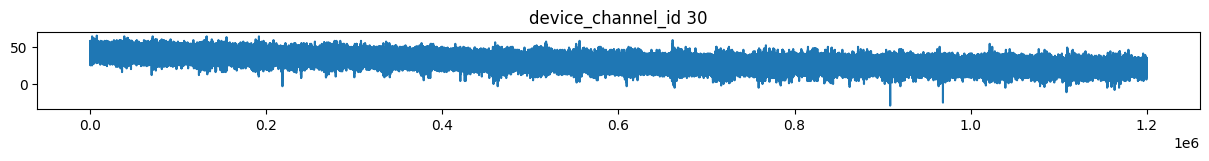

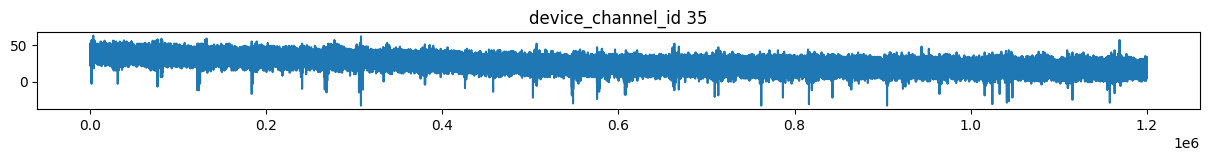

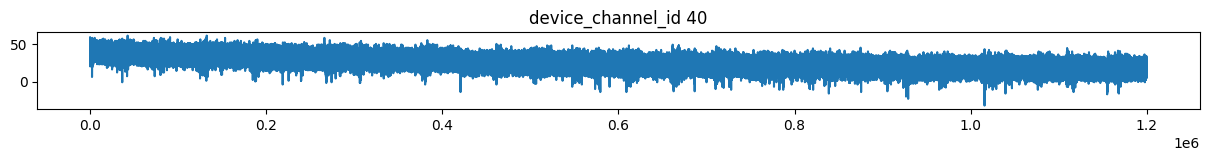

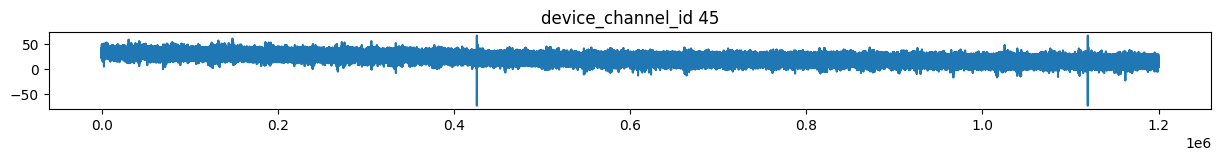

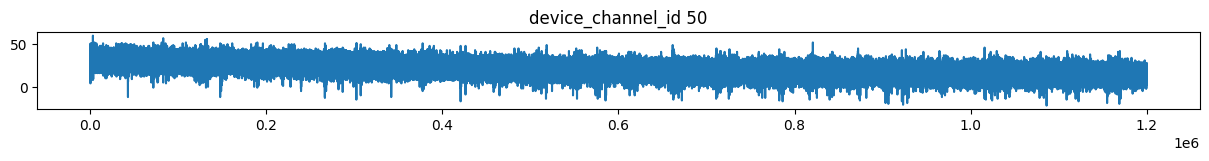

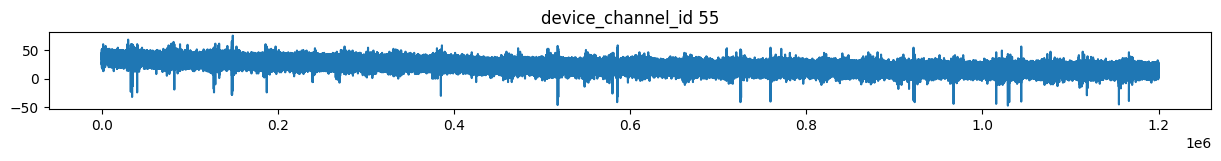

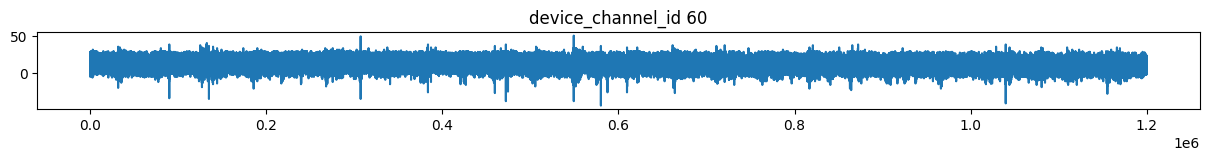

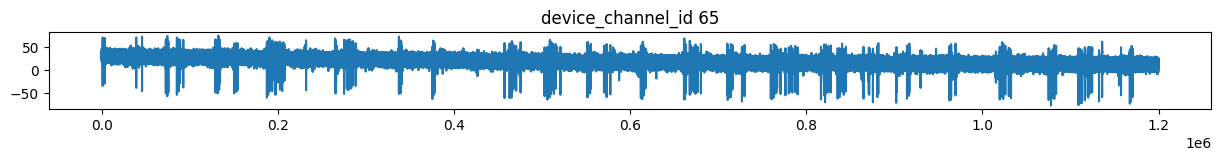

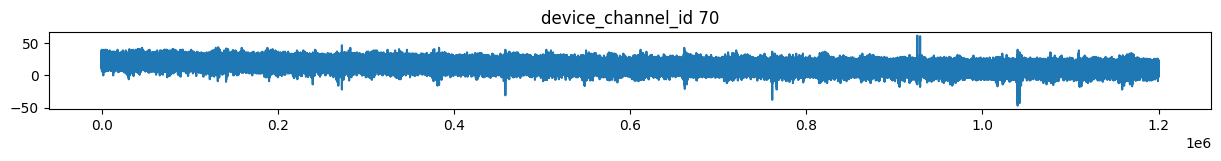

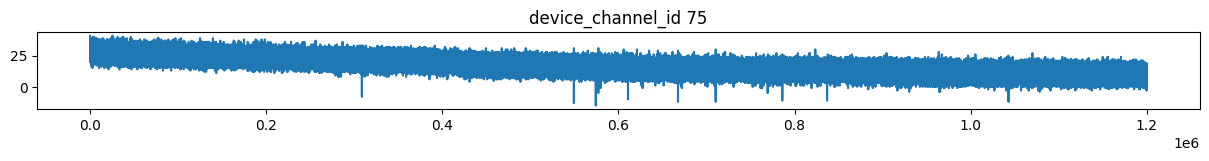

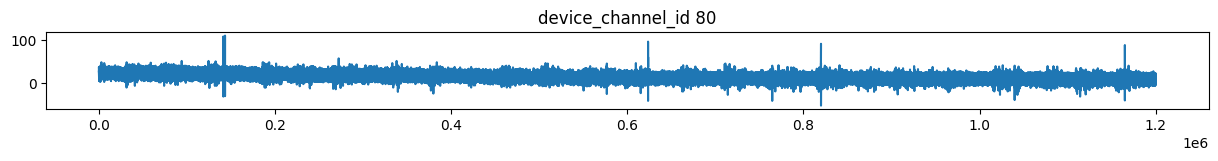

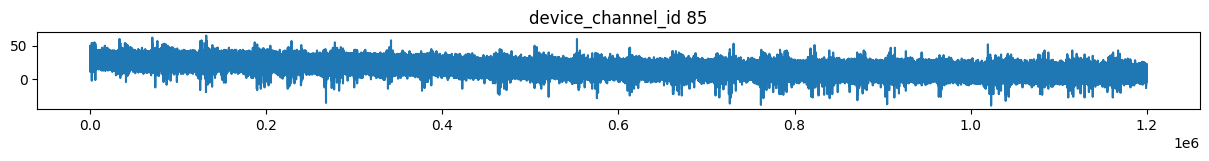

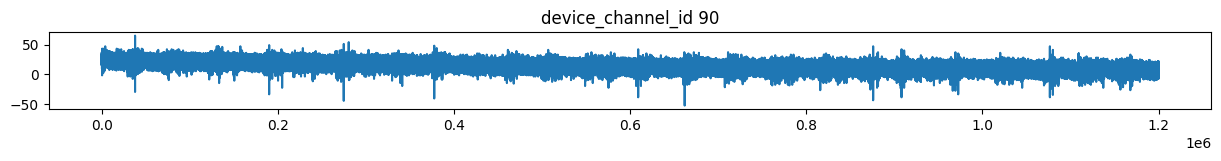

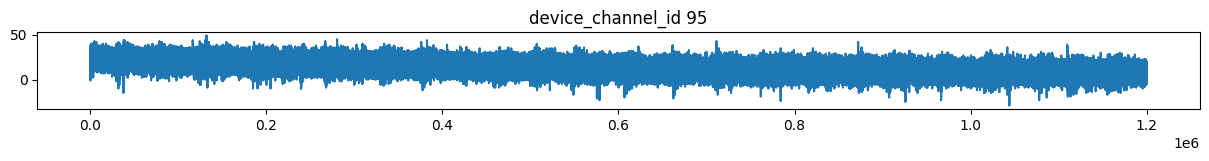

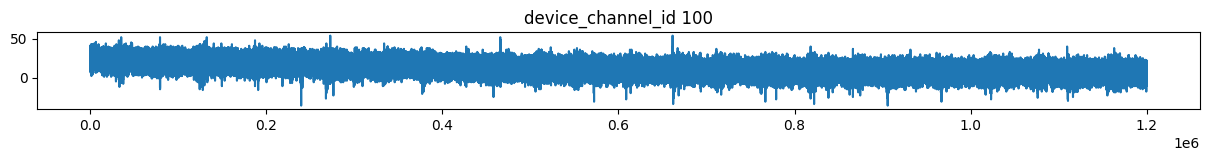

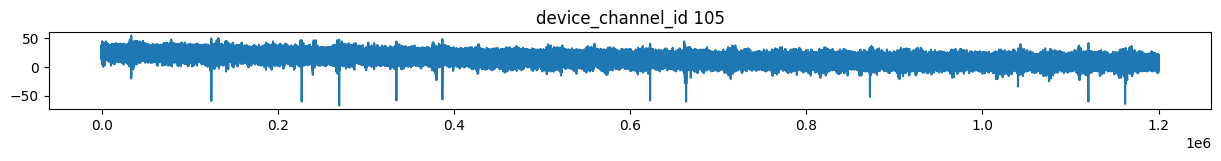

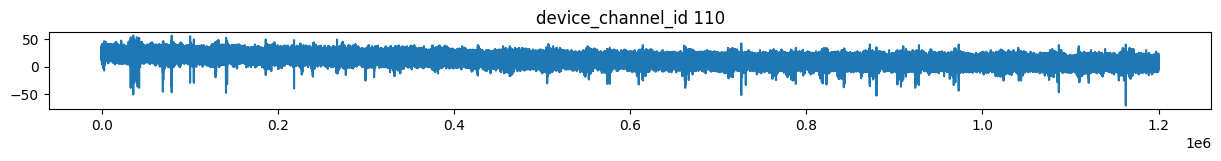

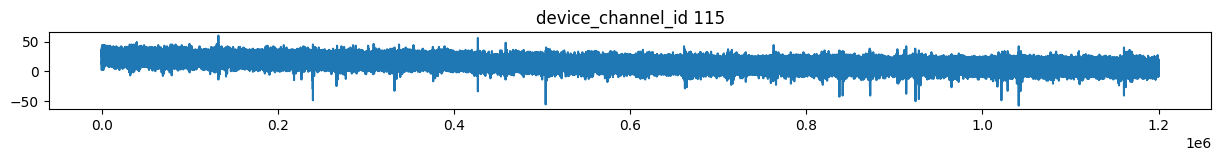

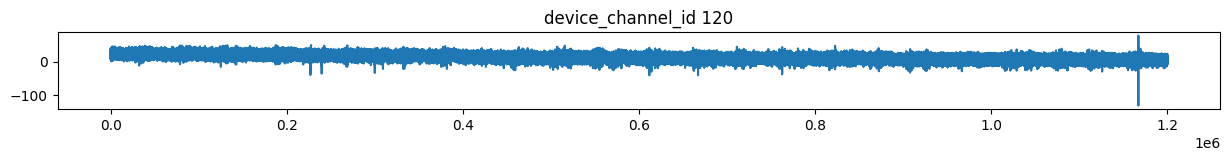

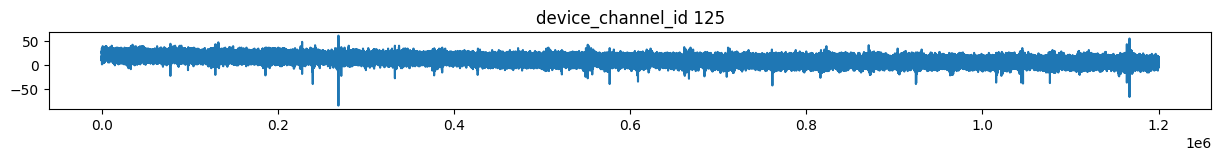

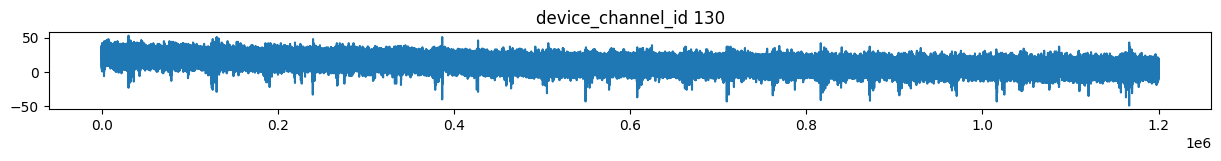

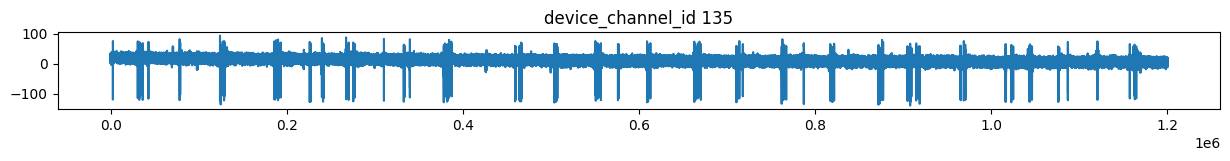

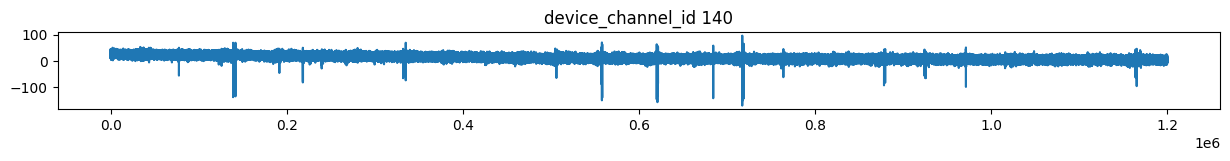

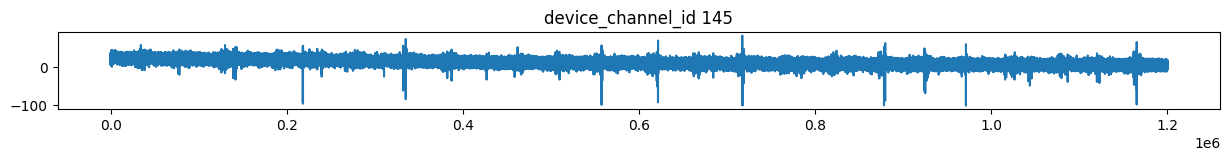

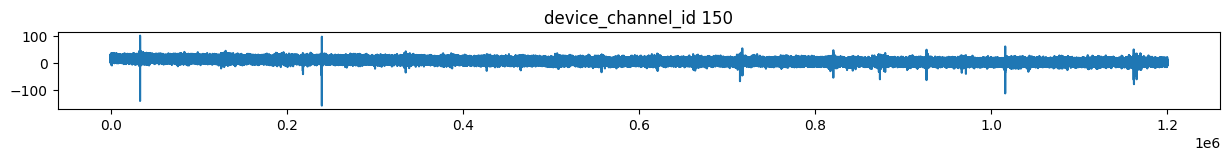

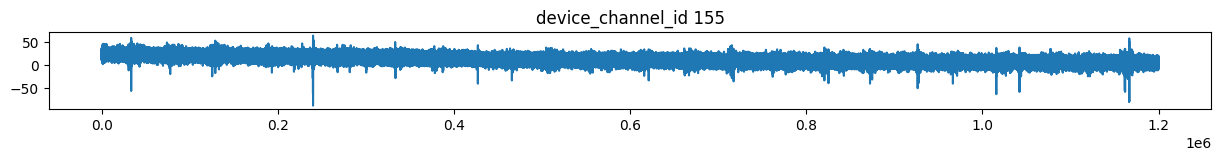

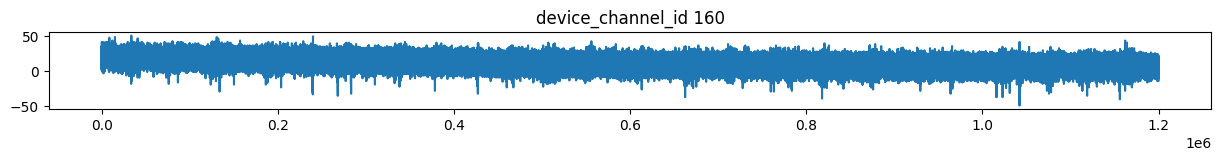

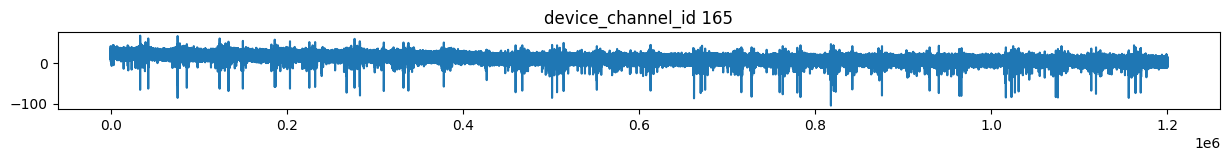

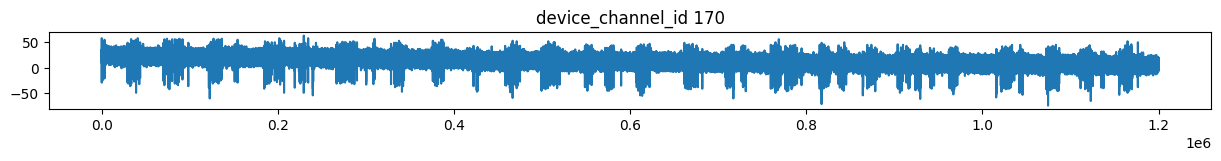

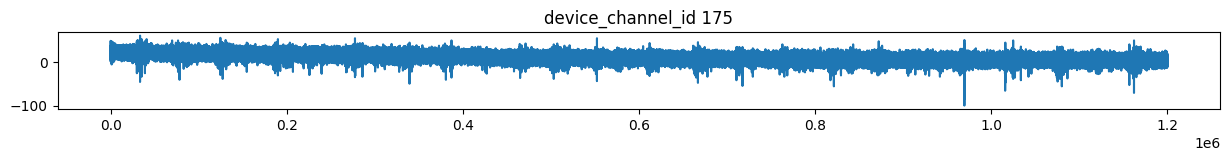

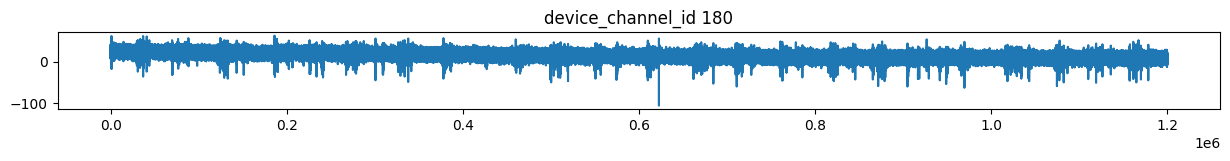

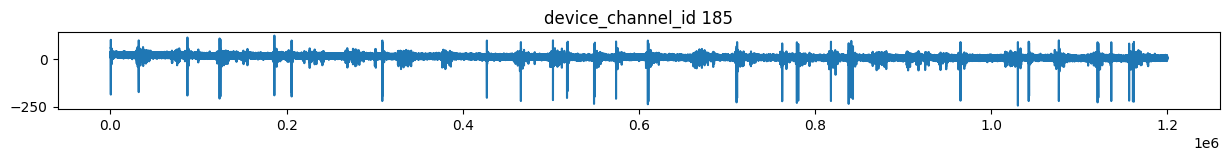

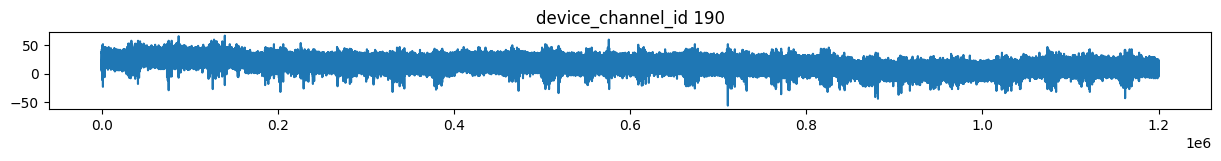

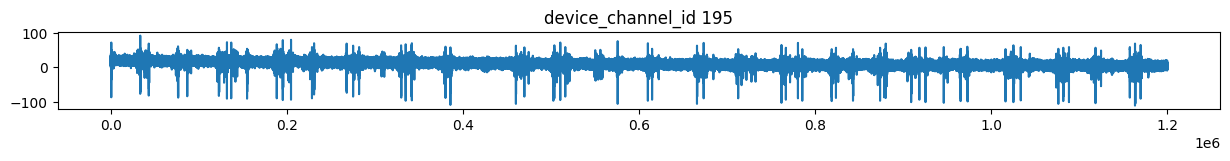

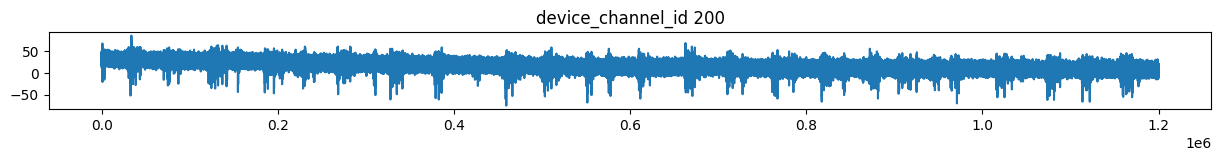

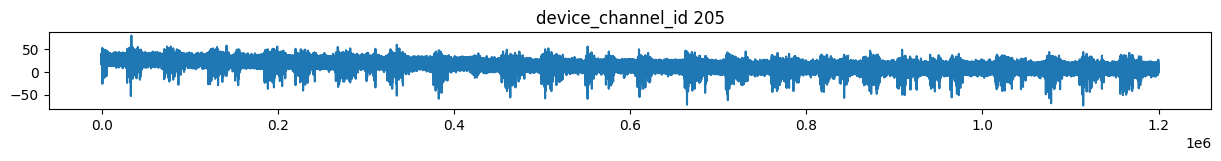

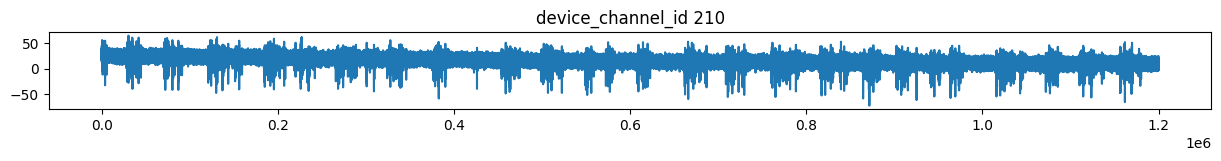

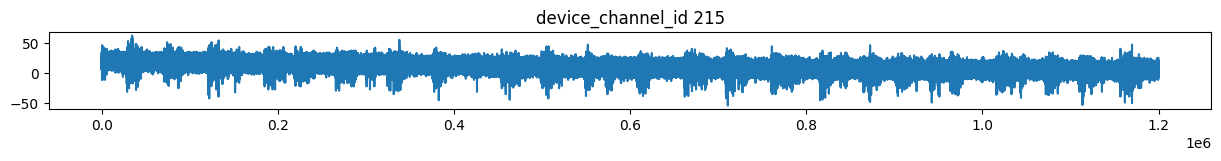

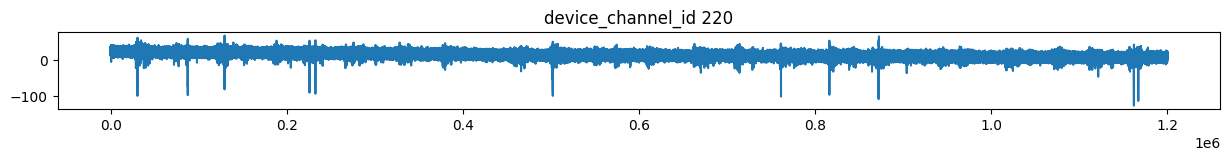

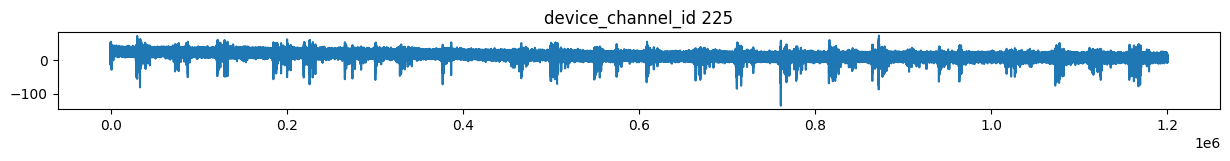

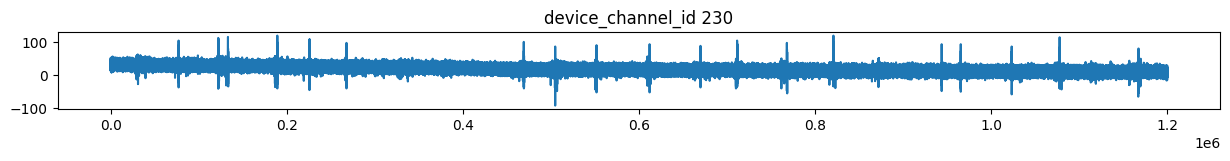

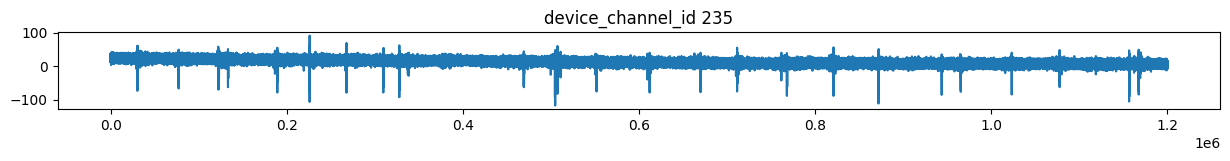

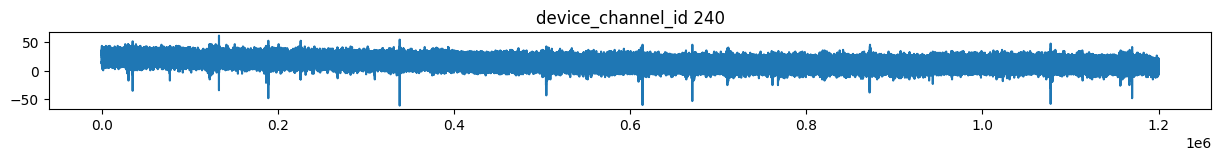

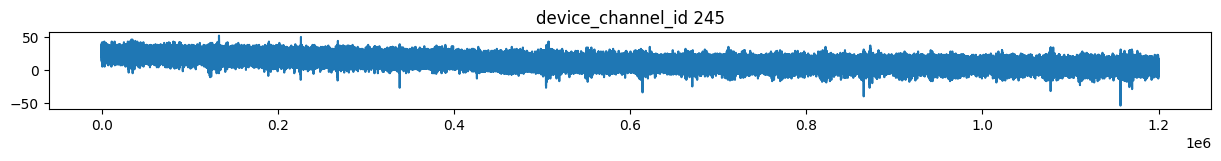

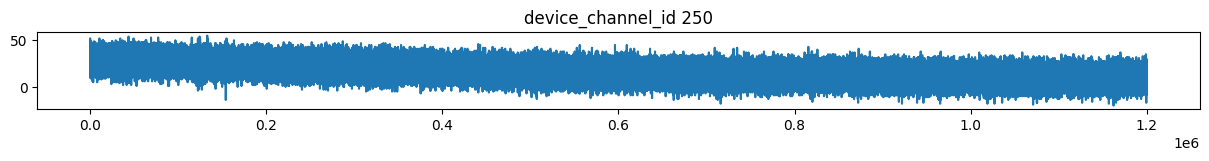

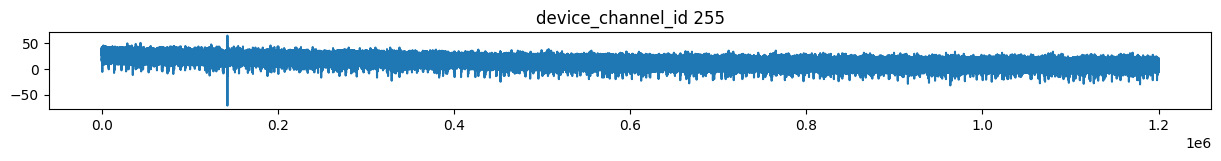

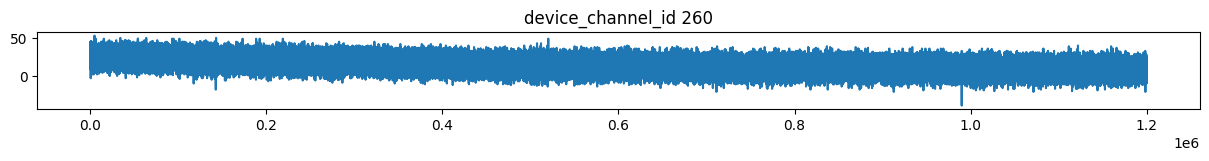

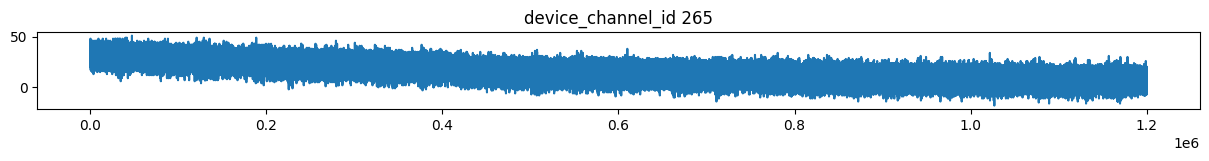

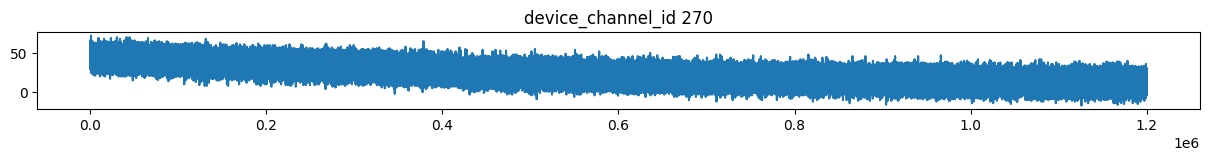

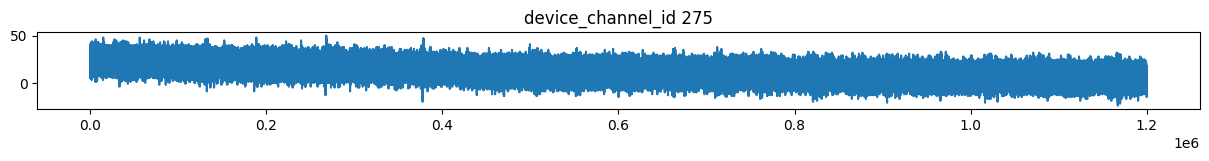

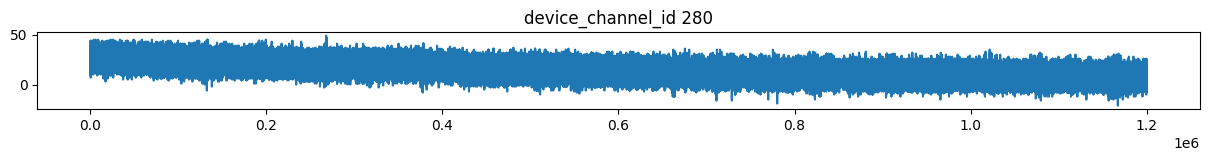

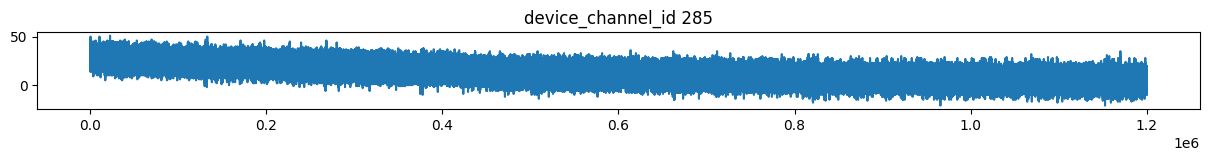

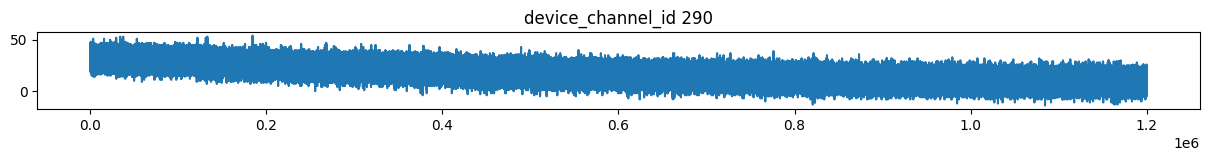

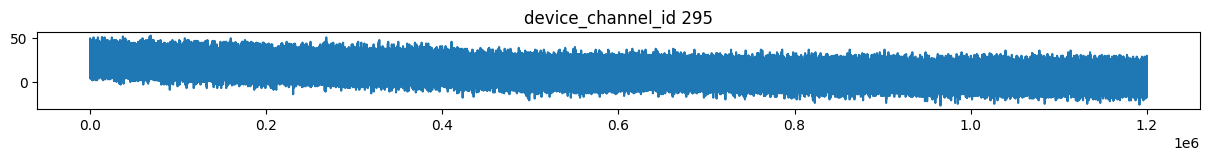

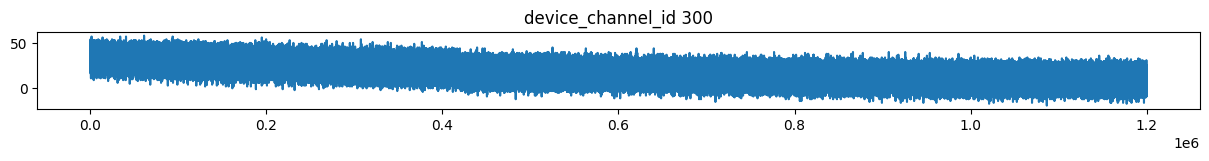

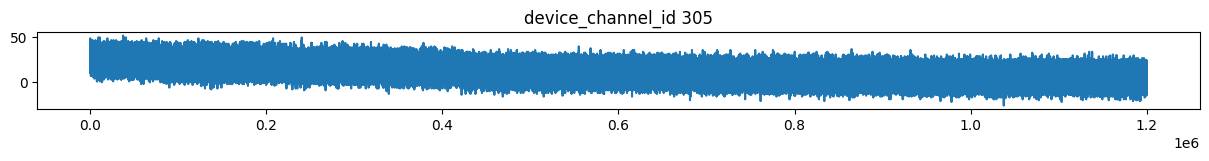

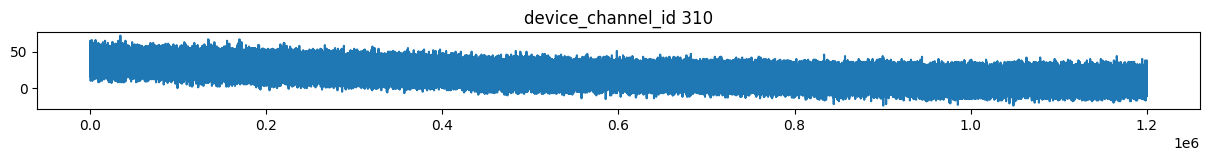

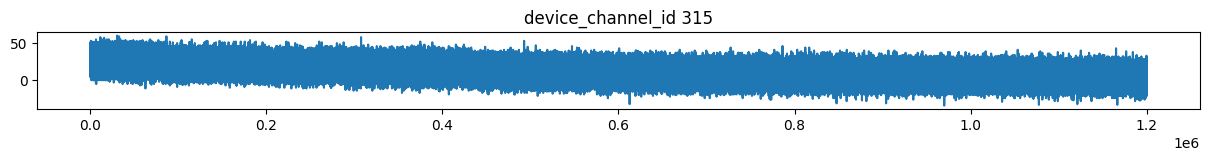

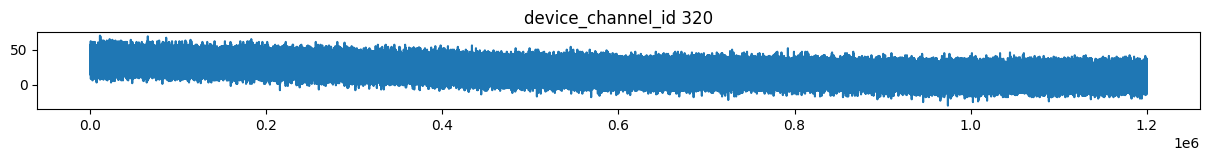

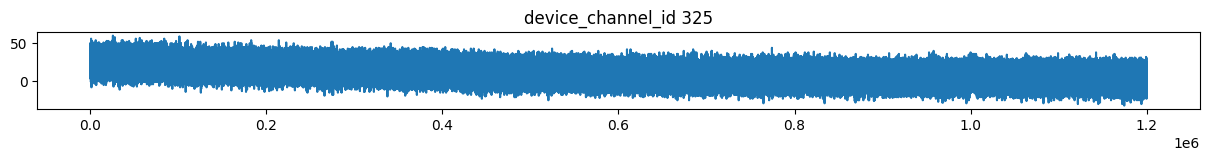

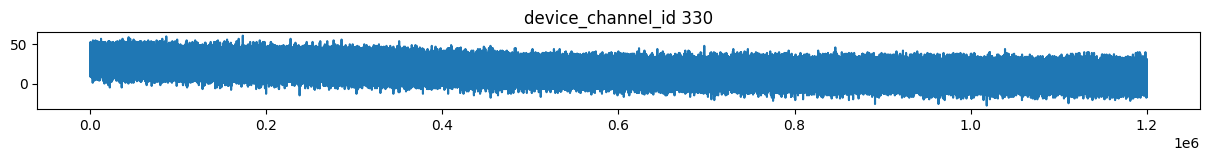

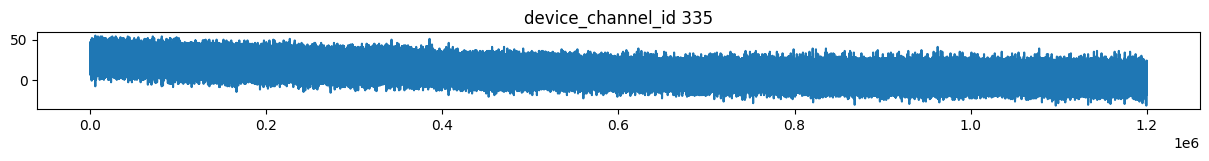

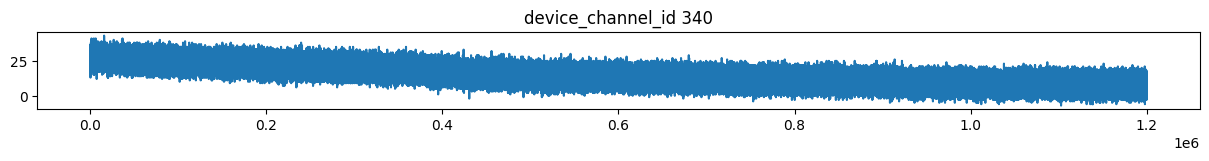

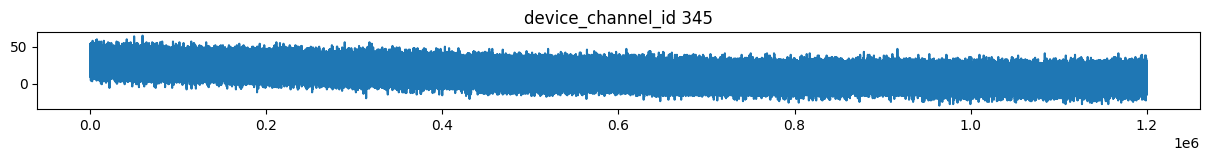

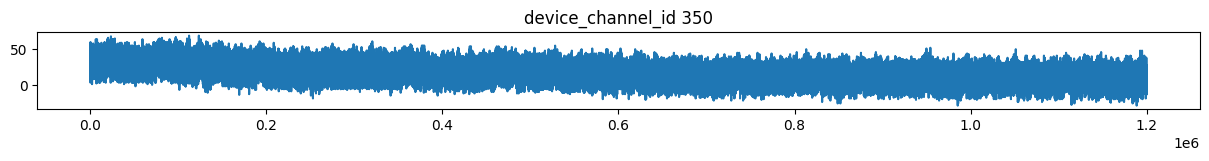

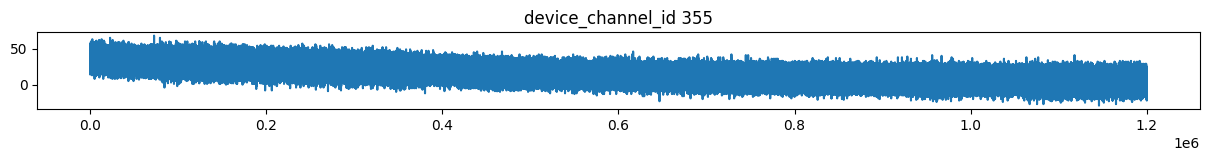

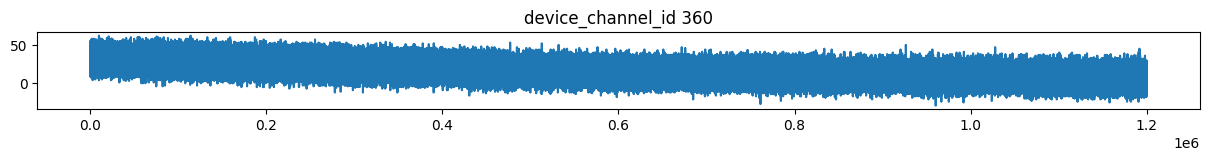

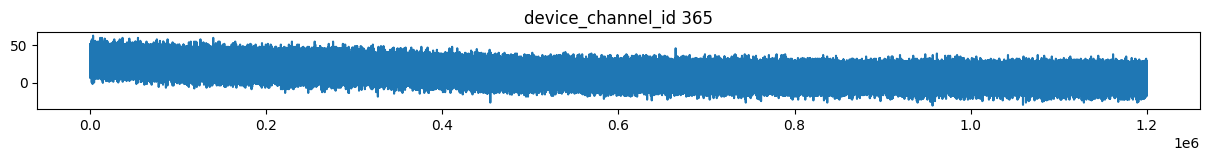

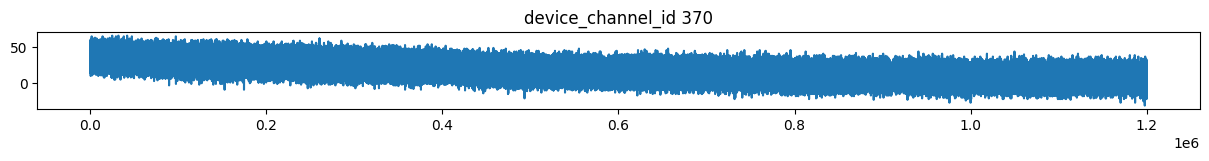

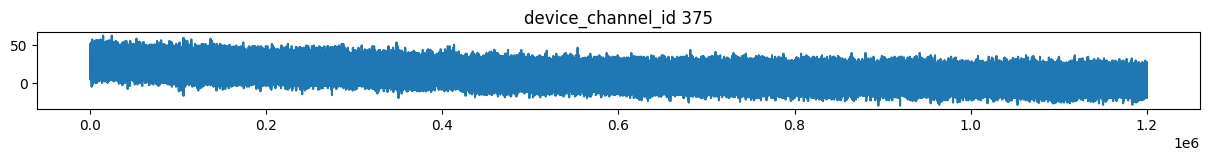

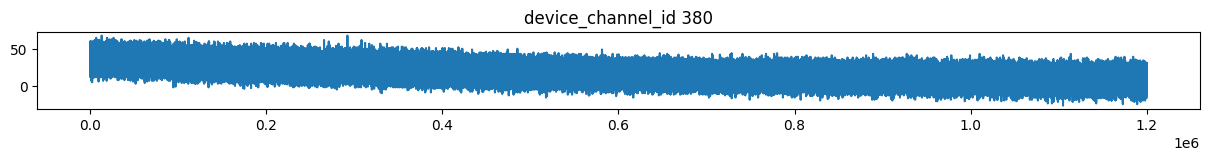

In [95]:
traces = Recording.get_traces()

window = np.arange(40*SAMPFREQ, 2*40*SAMPFREQ, 1)

# plot
for ix in range(384):
    if ix % 5 == 0:
        plt.subplots(1,1, figsize=(15,1))
        plt.plot(traces[window, ix])
        plt.title(f"device_channel_id {probe.device_channel_indices[ix]}")

## References

https://github.com/cortex-lab/neuropixels/wiki/Phase3_AB